In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy, os

from skimage import io, exposure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.draw import disk as pdisk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_otsu, threshold_li, threshold_multiotsu, rank
from skimage.filters import sobel

from scipy.stats import skew
from scipy.signal import argrelextrema
import concurrent.futures
from matplotlib.widgets import Slider
from pathlib import Path



In [2]:
PRECISION = 50

In [3]:
class IegImgParams(): 
    def __init__(self, path, thre, skewness, bgr):
        self.path = path
        self.thre = thre
        self.skewness = skewness
        self.bgr = bgr

In [4]:
class Approximation(): 
    def __init__(self, reg_props, approx_patch, intensity,  idno):
        self.reg_props = reg_props
        self.approx_patch = approx_patch
        self.intensity = intensity
        self.idno = idno

In [5]:
def background_filter(flattened_img):
    hist, bins = np.histogram(flattened_img, int(pow(PRECISION, 2)/20))
    mode_idx = np.argmax(hist)
    mode = bins[mode_idx]
    return mode

In [6]:
def reflect(image_ts):
    height = image_ts.shape[0]
    image_ts = np.transpose(image_ts)
    to_ret = np.copy(image_ts)
    for col_no, column in enumerate(image_ts):
        nonzero = False
        idx = 0
        while not nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        start_idx = idx - 1
        while nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        stop_idx = idx - 1
        reflection = np.flip(column[start_idx:stop_idx])
        reflect_offset_up = start_idx - len(reflection)
        reflect_offset_down = stop_idx + len(reflection)
        to_ret[col_no][max(0, reflect_offset_up):start_idx] = reflection[max(0, -reflect_offset_up):]
        to_ret[col_no][stop_idx:min(reflect_offset_down, height)] = reflection[:min(len(reflection)+1, height - stop_idx)]
    return np.transpose(to_ret)

In [7]:
def calculate_ieg_segm_params(image_ts):
    
    reflected = reflect(image_ts)
    #background = ndi.generic_filter(reflected, background_filter, size=PRECISION)
    background = np.ones_like(image_ts)
    skewness = skew(image_ts[image_ts>0])
    
    
    return threshold_otsu(image_ts[image_ts>0]), background, skewness

In [8]:
def ieg_segmentation(image_ts, thresh_down, thresh_up, thresh_range, mask): 

        
    elev_map = sobel(image_ts)
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
                                labels=mask)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-elev_map, markers, mask=mask)
    label_image = label(labels, connectivity = 1)
    
    
    masked = np.ma.masked_array(data = image_ts, mask = mask, fill_value = 0).filled()

    intensities_normalized = np.array([])
    dots = np.array([])
    
    for region in regionprops(label_image, intensity_image=image_ts):
        reg_app_w_bgr = pdisk(region.centroid, 7, shape = image_ts.shape)
        reg_approx = pdisk(region.centroid, 5, shape = image_ts.shape)
        reg_intensity = 2*np.sum(image_ts[reg_approx]) - np.sum(image_ts[reg_app_w_bgr])
        circ = mpatches.Circle((region.centroid[1], region.centroid[0]), 5, 
                               fill=False, edgecolor="red", linewidth=2)
        new_dot = Approximation(region, copy.copy(circ), reg_intensity, len(dots))
        dots = np.append(dots, new_dot)
        intensities_normalized = np.append(intensities_normalized, reg_intensity)



    return dots, intensities_normalized

In [9]:
scan_path_root = "/home/ula/catfish/test_scans/"

suffix = "/2.tif"
overlay_suffix = "/overlay2.tif"
hist_suffix = "_hist.png"

In [10]:
def process_scan(img_path):
    print(img_path)
    ieg_img = io.imread(img_path)
    thre, background, skewness = calculate_ieg_segm_params(ieg_img)
    res = IegImgParams(img_path, thre, skewness, background)
    return res

In [11]:
def plot_intensities_normalized(result, k1, k2):

    ieg_img = io.imread(result.path)

    mask = ieg_img > (threshold_otsu(ieg_img[ieg_img>0]))#*k1/result.skewness + result.bgr*k2)
    dots, intensities_normalized = ieg_segmentation(ieg_img, 0, 30, 21, mask)

    #hist, bins = np.histogram(intensities_normalized, 200)
    #bins = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
    
    
    plt.hist(intensities_normalized, 200)
    figure = plt.gcf() # get current figure
    print(os.path.dirname(result.path) + hist_suffix)
    print(len(dots))
    fig_path = os.path.dirname(result.path) + hist_suffix
    plt.show()
    '''
    plt.savefig(fig_path)
    plt.clf()
    #return hist, bins
    '''


In [12]:
#MAIN loop to walk through img folder, looking for FOLDERS
to_process = np.array([])

for filename in os.listdir(scan_path_root):
    path = scan_path_root + filename
    if os.path.isdir(path):
        to_process = np.append(to_process, path + suffix)

results = np.array([])

with concurrent.futures.ProcessPoolExecutor(8) as executor: 
    for result in executor.map(process_scan, to_process):
        results = np.append(results, result)
        #plot_intensities_normalized(result, 5, 0)
plt.close()

/home/ula/catfish/test_scans/CA1_left_glass_1_rat_2_hipp_left_skan_2019-10-08_105903/2.tif/home/ula/catfish/test_scans/Amyg_CE_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619/2.tif/home/ula/catfish/test_scans/DG_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039/2.tif/home/ula/catfish/test_scans/CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039/2.tif/home/ula/catfish/test_scans/RSGc_right_glass_23_rat_20_rsd_rsgc_right_skan_2019-10-28_103719/2.tif/home/ula/catfish/test_scans/Amyg_LA_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619/2.tif





/home/ula/catfish/test_scans/CA3_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039/2.tif
/home/ula/catfish/test_scans/RSD_right_glass_23_rat_20_rsd_rsgc_right_skan_2019-10-28_103719/2.tif
/home/ula/catfish/test_scans/Amyg_BLA_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619/2.tif


In [19]:
len(results)

9

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


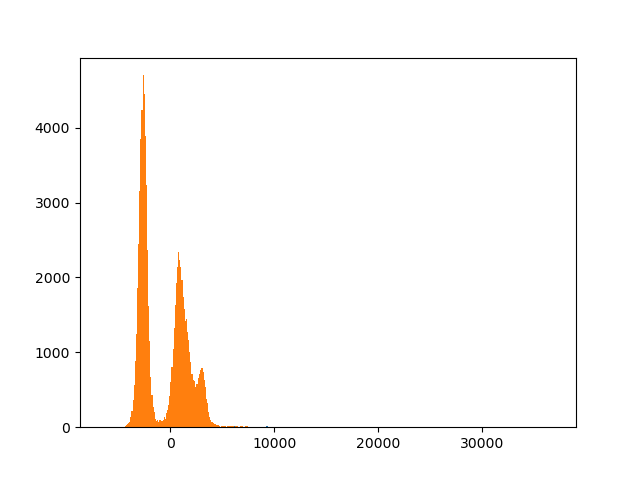

/home/ula/catfish/test_scans/CA1_left_glass_1_rat_2_hipp_left_skan_2019-10-08_105903_hist.png
355


In [21]:
plot_intensities_normalized(results[0], 5, 0)

In [22]:
plot_intensities_normalized(results[1], 5, 0)

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/Amyg_CE_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619_hist.png
83262


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


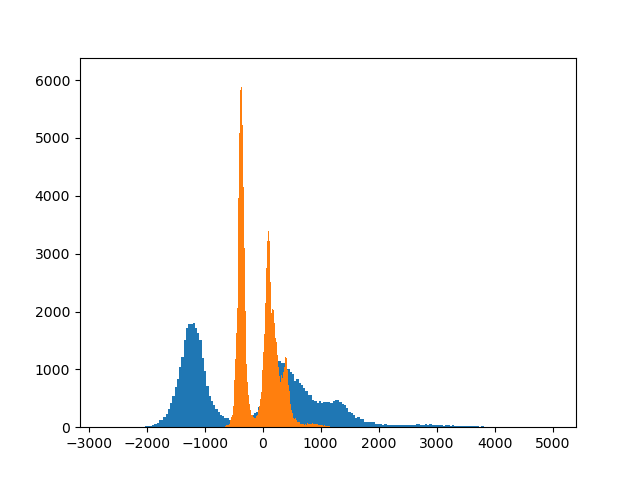

/home/ula/catfish/test_scans/CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039_hist.png
56513


In [23]:
plot_intensities_normalized(results[2], 5, 0)

In [24]:
plot_intensities_normalized(results[3], 5, 0)

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/CA3_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039_hist.png
120387


/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


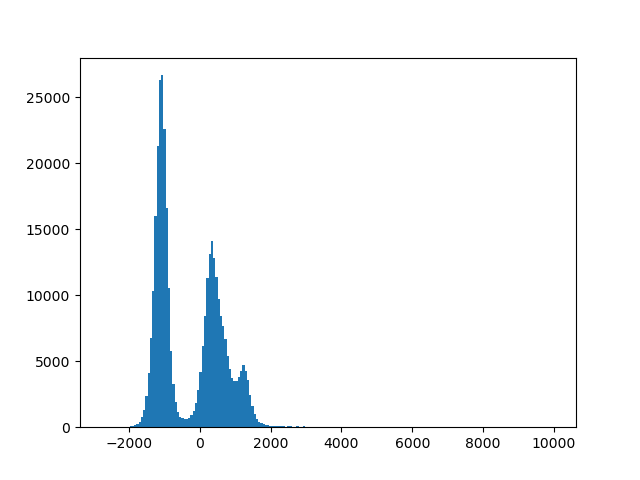

/home/ula/catfish/test_scans/RSD_right_glass_23_rat_20_rsd_rsgc_right_skan_2019-10-28_103719_hist.png
352447


In [25]:
plot_intensities_normalized(results[4], 5, 0)

In [ ]:
plot_intensities_normalized(results[5], 5, 0)

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [16]:
def draw_ieg_dots(result, k1, k2, cutoff):
    ax = plt.subplot(aspect='equal')
    
    ieg_img = io.imread(result.path)
    mask = ieg_img > (threshold_otsu(ieg_img[ieg_img>0])*k1/result.skewness + result.bgr*k2)
    dots, intensities_normalized = ieg_segmentation(ieg_img, 0, 30, 21, mask)
    plt.imshow(ieg_img)
    for dot in dots:
        if dot.intensity > -445.89:
            dot.approx_patch.set_edgecolor("white")
        else:
            dot.approx_patch.set_edgecolor("red")
        ax.add_artist(dot.approx_patch)
    plt.show()
    return intensities_normalized

In [17]:
i_n = draw_ieg_dots(results[0], 5, 100, 500)

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


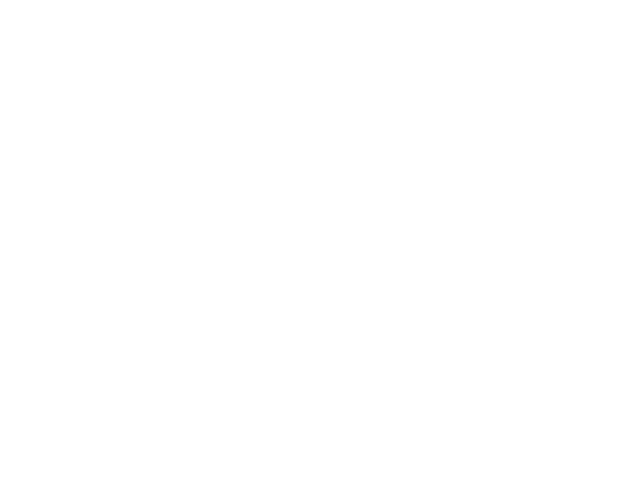

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/home/ula/catfish/test_scans/CA1_left_glass_1_rat_2_hipp_left_skan_2019-10-08_105903_hist.png
355


TypeError: cannot unpack non-iterable NoneType object

In [18]:
from matplotlib.widgets import Slider, Button, RadioButtons

axis_color = 'lightgoldenrodyellow'

fig = plt.figure()
ax = fig.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.25, bottom=0.25)


k1 = 5
k2 = 0

hist, bins = plot_intensities_normalized(results[0], k1, k2)

# Draw the initial plot
# The 'line' variable is used for modifying the line later
[line] = ax.plot(bins, hist, linewidth=2, color='red')


k1_slider_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
k1_slider = Slider(k1_slider_ax, 'k1', 0, 10.0, valinit=5)

# Draw another slider
k2_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
k2_slider = Slider(k2_slider_ax, 'k2', 0, 30.0, valinit=0.5)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    hist, bins = plot_intensities_normalized(results[0], k1_slider.val, k2_slider.val)
    line.set_xdata(bins)
    line.set_ydata(hist)
    fig.canvas.draw_idle()
k1_slider.on_changed(sliders_on_changed)
k2_slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
def reset_button_on_clicked(mouse_event):
    k1_slider.reset()
    k2_slider.reset()
reset_button.on_clicked(reset_button_on_clicked)

# Add a set of radio buttons for changing color
'''
color_radios_ax = fig.add_axes([0.025, 0.5, 0.15, 0.15], facecolor=axis_color)
color_radios = RadioButtons(color_radios_ax, ('red', 'blue', 'green'), active=0)
def color_radios_on_clicked(label):
    line.set_color(label)
    fig.canvas.draw_idle()
color_radios.on_clicked(color_radios_on_clicked)
'''
plt.show()